Check Python version

In [399]:
!python --version

Python 3.10.6


Import libraries

In [400]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [401]:
# Local directory
#data_dir = "../datasets/climate"
#file_name = "temp_anom_w_forcing"
data_dir = "../datasets/finance"
file_name = "Returns_short_interest_data_train"
file_path = f"{data_dir}/{file_name}.csv"

# Through online GitHub
# file_path = "https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv"

In [402]:
dataset = pd.read_csv(file_path)

In [403]:
dataset.shape

(788, 15)

In [404]:
dataset.columns

Index(['date', 'log_dp', 'log_dy', 'log_ep', 'log_de', 'bm', 'ntis', 'tbl',
       'lty', 'ltr', 'tml', 'dfy', 'dfr', 'infl_lag', 'target'],
      dtype='object')

In [405]:
dataset.head()

,date,log_dp,log_dy,log_ep,log_de,bm,ntis,tbl,lty,ltr,tml,dfy,dfr,infl_lag,target
0,1937-05-01,-2.999429,-2.999429,-2.648946,-0.350483,0.489382,0.028278,0.0041,0.0282,0.0053,0.0241,0.0151,-0.0013,-2.999429,-0.006041
1,1937-06-01,-2.908721,-2.908721,-2.577364,-0.331357,0.504961,0.031266,0.0036,0.0285,-0.0018,0.0249,0.0165,0.0071,-2.908721,-0.054103
2,1937-07-01,-3.034560,-3.034560,-2.660885,-0.373675,0.464649,0.027225,0.0028,0.0277,0.0138,0.0249,0.0166,-0.0099,-3.034560,0.098758
3,1937-08-01,-3.006598,-3.006598,-2.589993,-0.416605,0.481935,0.031064,0.0029,0.0286,-0.0104,0.0257,0.0168,0.0087,-3.006598,-0.051425
4,1937-09-01,-2.883131,-2.883131,-2.422915,-0.460216,0.553147,0.035847,0.0031,0.0284,0.0045,0.0253,0.0188,-0.0020,-2.883131,-0.139868


In [406]:
dataset.tail()

,date,log_dp,log_dy,log_ep,log_de,bm,ntis,tbl,lty,ltr,tml,dfy,dfr,infl_lag,target
783,2002-08-01,-4.054990,-4.054990,-3.454868,-0.600122,0.284412,0.025483,0.0162,0.0510,0.0464,0.0348,0.0121,-0.0012,-4.054990,0.005711
784,2002-09-01,-3.943471,-3.943471,-3.301014,-0.642457,0.324555,0.029393,0.0163,0.0480,0.0417,0.0317,0.0125,-0.0087,-3.943471,-0.110377
785,2002-10-01,-4.020567,-4.020567,-3.411479,-0.609089,0.293437,0.025778,0.0158,0.0508,-0.0294,0.0350,0.0141,0.0054,-4.020567,0.087282
786,2002-11-01,-4.070296,-4.070296,-3.495323,-0.574973,0.276975,0.023009,0.0123,0.0521,-0.0122,0.0398,0.0131,0.0252,-4.070296,0.057994
787,2002-12-01,-4.002328,-4.002328,-3.462264,-0.540064,0.295386,0.025838,0.0119,0.0484,0.0507,0.0365,0.0124,-0.0146,-4.002328,-0.059826


In [407]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change 'target' to float

In [408]:
# dataset[target_col] = dataset[target_col].astype(float)

In [409]:
# dataset.head()

In [410]:
training_points = int(0.8*len(dataset))
train_df = dataset.iloc[:training_points]
test_df = dataset.iloc[training_points:]

Plot graph

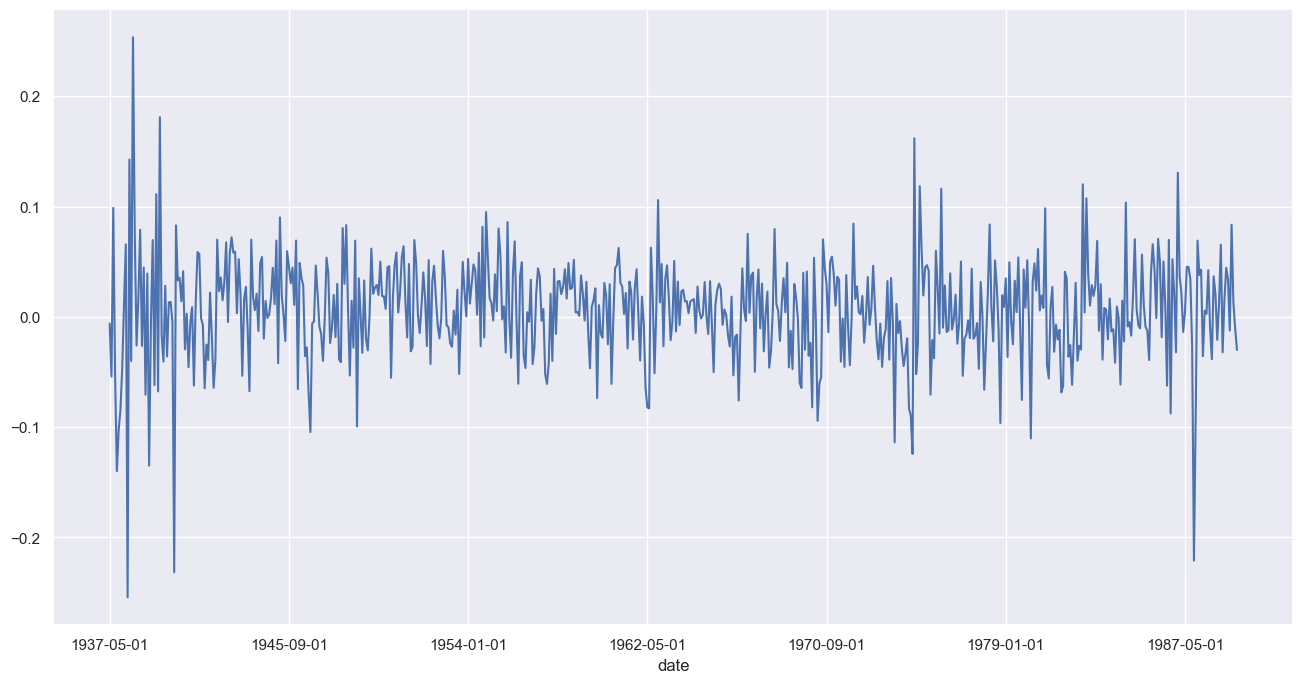

In [411]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [412]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [413]:
train_data[:2]

[['1937-05-01',
  -2.9994291354353173,
  -2.9994291354353173,
  -2.648946161744506,
  -0.3504829736908111,
  0.4893824051284986,
  0.0282780631029591,
  0.0040999999999999,
  0.0282,
  0.0053,
  0.0241,
  0.0150999999999999,
  -0.0013,
  -2.9994291354353173,
  -0.0060406666666666],
 ['1937-06-01',
  -2.908720896564361,
  -2.908720896564361,
  -2.5773637606099187,
  -0.3313571359544425,
  0.5049610205527995,
  0.0312661665365891,
  0.0036,
  0.0285,
  -0.0018,
  0.0249,
  0.0165,
  0.0071,
  -2.908720896564361,
  -0.054103]]

Custom Model Request (optional)

In [414]:
custom_model_request = {
    'type': 'meta_lr',
    'scorers': ['smape', 'mape'],
    'params': {
        'base_models': [
            #{'type': 'darts_autoarima'},
            {'type': 'darts_autotheta'},
            {'type': 'darts_autoets'},
            {'type': 'stats_autotheta'}
        ]
    }
}

Train API JSON Payload

In [415]:
api_json = {
    'data': train_data,
    'model': custom_model_request,
}

Build URL

In [416]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [417]:
# URL to our SYBIL AWS service
protocol = url_dict["protocol"]
host = url_dict["host"]
port = url_dict["port"]
endpoint = "train"

url = "%s://%s:%s/%s" % (protocol, host, str(port), endpoint)

In [418]:
protocol, host, port

('http', 'localhost', 80)

Call endpoint, receive response JSON, write to output file

In [419]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

CPU times: total: 0 ns
Wall time: 24.5 s


In [420]:
train_json_out = response.json()  # dict output
# train_json_out = json.dumps(response.json())  # str output
# train_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [421]:
train_json_out

{'model': 'AgEBCObXAgDg1wIAPmYCABgAAAA0ZgIA/FoAAIAALnCUaZRhcmFsb4xJk4xnbl8SY2lygW1uZWFnaWNyXWFpYm54bmVzYzSUdHBtYWN0bWFLhw10AlKU/3QAAAAAAAAAAAAAAAAAlJRdhSguhzL/dAgIHapyr9TrLV1DkAiUH2iHDQECAwQFBgcICQoLDA2UhgZ9c2+UZWeMbmMNYV9lX2EFlHNsbGFoaZRzcmGUKGxncGxlD2yUAJQCMShO/2IAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [422]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

In [423]:
test_data[:2]

[['1989-11-01',
  -3.455508698863343,
  -3.455508698863343,
  -2.7047031108088846,
  -0.7508055880544587,
  0.3972257017961992,
  -0.0270221107060077,
  0.0769,
  0.0808,
  0.0078,
  0.0038999999999999,
  0.0092,
  -0.0007999999999999,
  -3.455508698863343],
 ['1989-12-01',
  -3.465170131921834,
  -3.465170131921834,
  -2.7377745518509062,
  -0.727395580070928,
  0.3904547435711172,
  -0.0123231066872625,
  0.0762999999999999,
  0.0816,
  -0.0006,
  0.0053,
  0.0096,
  0.0012,
  -3.465170131921834]]

Model from Train API

In [424]:
model = train_json_out["model"]

Forecast API JSON Payload

In [425]:
api_json = {
    'model': model,
    'predicts': test_data
}

Build URL (same as train except for the endpoint)

In [426]:
endpoint = "forecast"

url = "%s://%s:%s/%s" % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [427]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

CPU times: total: 15.6 ms
Wall time: 199 ms


In [428]:
forecast_json_out = response.json()  # dict output
# forecast_json_out = json.dumps(response.json())  # str output
# forecast_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [429]:
forecast_json_out

{'data': [['1989-10-31T00:00:00', 0.008075387152652727],
  ['1989-11-30T00:00:00', 0.004829473960041468],
  ['1989-12-30T00:00:00', 0.002393972839184398],
  ['1990-01-29T00:00:00', 0.004738382739739047],
  ['1990-02-28T00:00:00', 0.004490729045408842],
  ['1990-03-30T00:00:00', 0.00027381743411902023],
  ['1990-04-29T00:00:00', 0.010396013787377839],
  ['1990-05-29T00:00:00', 0.006260586586544764],
  ['1990-06-28T00:00:00', 0.003664576777463444],
  ['1990-07-28T00:00:00', -0.0013615438588959051],
  ['1990-08-27T00:00:00', 0.0031717720007046228],
  ['1990-09-26T00:00:00', 0.00454585996596002],
  ['1990-10-26T00:00:00', 0.0073783101644384775],
  ['1990-11-25T00:00:00', 0.00705151261124304],
  ['1990-12-25T00:00:00', 0.006967900558467835],
  ['1991-01-24T00:00:00', 0.006722412748338907],
  ['1991-02-23T00:00:00', 0.007206156920129867],
  ['1991-03-25T00:00:00', 0.00574577784494344],
  ['1991-04-24T00:00:00', 0.005500679047965178],
  ['1991-05-24T00:00:00', 0.001934263889343294],
  ['1991-

Combine forecast dates and output

In [430]:
forecast_df = pd.DataFrame(forecast_json_out["data"], columns = [time_col, target_col])

In [431]:
forecast_df.shape

(158, 2)

In [432]:
forecast_df.columns

Index(['date', 'target'], dtype='object')

In [433]:
forecast_df.head()

,date,target
0,1989-10-31T00:00:00,0.008075
1,1989-11-30T00:00:00,0.004829
2,1989-12-30T00:00:00,0.002394
3,1990-01-29T00:00:00,0.004738
4,1990-02-28T00:00:00,0.004491


In [434]:
forecast_df.tail()

,date,target
153,2002-05-26T00:00:00,0.018184
154,2002-06-25T00:00:00,0.014377
155,2002-07-25T00:00:00,0.005547
156,2002-08-24T00:00:00,0.015835
157,2002-09-23T00:00:00,0.014134


Plot train and forecast side-by-side

C:\Users\User\AppData\Local\Temp\ipykernel_13732\28132996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["color"] = "b"


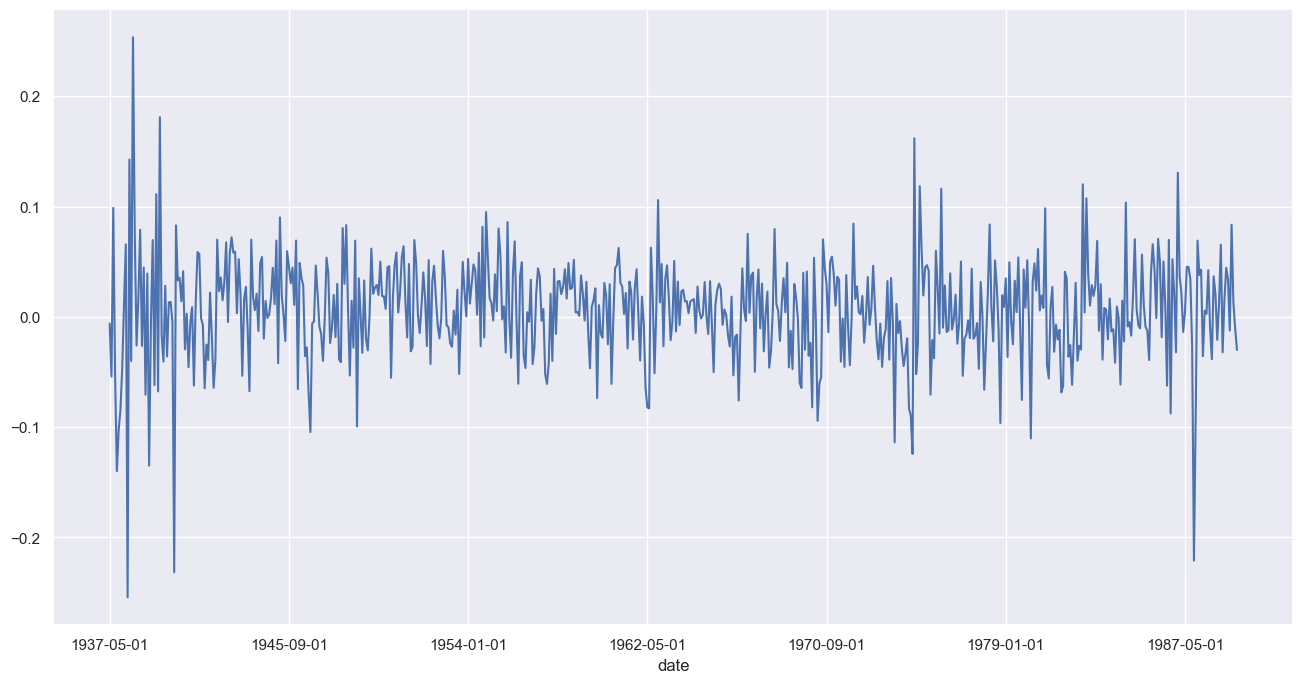

In [435]:
train_df["color"] = "b"
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df["color"]);

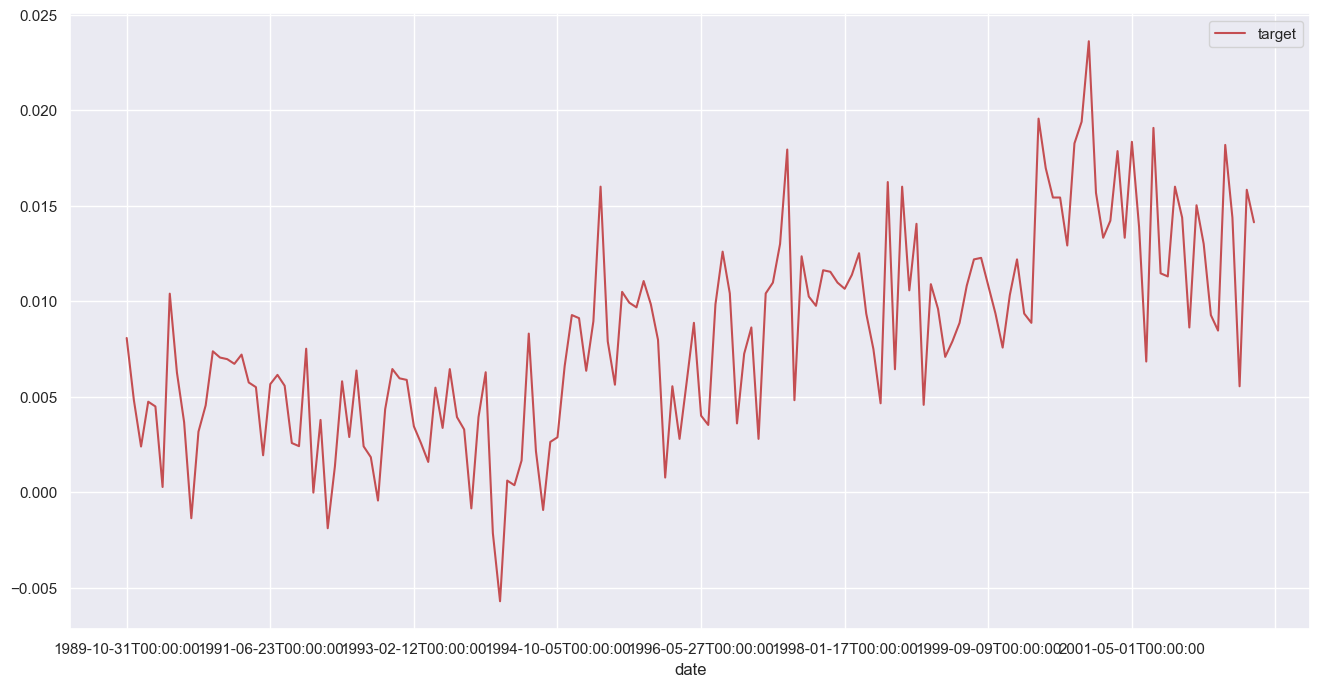

In [436]:
forecast_df["color"] = "r"
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df["color"]);

Combine train and test sets

In [437]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [438]:
df.shape

(788, 16)

In [439]:
df.head()

,date,log_dp,log_dy,log_ep,log_de,bm,ntis,tbl,lty,ltr,tml,dfy,dfr,infl_lag,target,color
0,1937-05-01,-2.999429,-2.999429,-2.648946,-0.350483,0.489382,0.028278,0.0041,0.0282,0.0053,0.0241,0.0151,-0.0013,-2.999429,-0.006041,b
1,1937-06-01,-2.908721,-2.908721,-2.577364,-0.331357,0.504961,0.031266,0.0036,0.0285,-0.0018,0.0249,0.0165,0.0071,-2.908721,-0.054103,b
2,1937-07-01,-3.034560,-3.034560,-2.660885,-0.373675,0.464649,0.027225,0.0028,0.0277,0.0138,0.0249,0.0166,-0.0099,-3.034560,0.098758,b
3,1937-08-01,-3.006598,-3.006598,-2.589993,-0.416605,0.481935,0.031064,0.0029,0.0286,-0.0104,0.0257,0.0168,0.0087,-3.006598,-0.051425,b
4,1937-09-01,-2.883131,-2.883131,-2.422915,-0.460216,0.553147,0.035847,0.0031,0.0284,0.0045,0.0253,0.0188,-0.0020,-2.883131,-0.139868,b


In [440]:
df.tail()

,date,log_dp,log_dy,log_ep,log_de,bm,ntis,tbl,lty,ltr,tml,dfy,dfr,infl_lag,target,color
783,2002-05-26T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018184,r
784,2002-06-25T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014377,r
785,2002-07-25T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005547,r
786,2002-08-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015835,r
787,2002-09-23T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014134,r


Plot combined train and test sets with the vertical black line as the cut-off

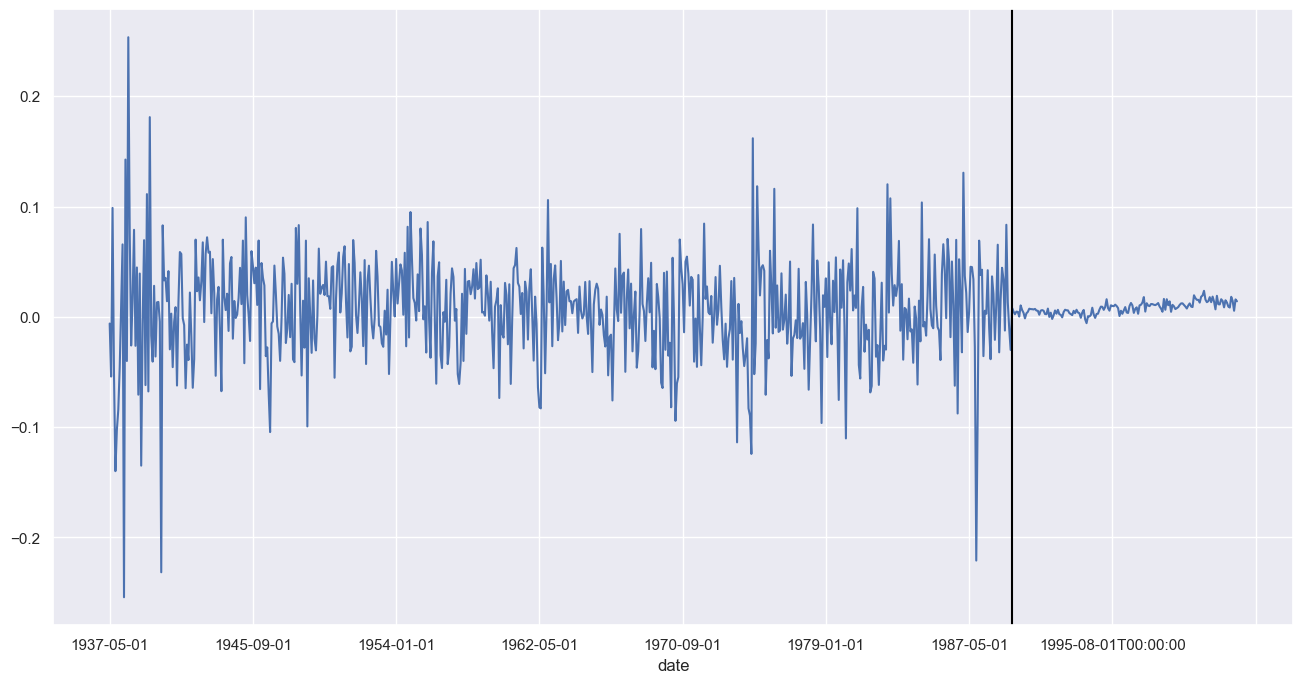

In [441]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color=df["color"])
plt.axvline(x=len(train_df), color='black', label ='Train/Test set cut-off')
plt.show();